# Setup

In [1]:
#import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2 as cv
import math
import os
import keras_tuner
import random

import train
import evaluate
import img_display


# Dataset loading

Dataset is loaded from csv files contained in a directory, where pixel information of the images (0-255) is stored together with labels.
This loading is performed using a Trainer object, which also contains visualization methods, and performs the resizing and normalization of images.

Parameter for Trainer should be explicitely called, since it accepts several data source (pict = image array, data = image + labels array
or datapath = directory containing annotated csv files)

The Trainer default label-picture split is performed for image size of 76*82 in the dataset.
It also removes any picture labelled with a 0 (errors).

(5131, 6233)


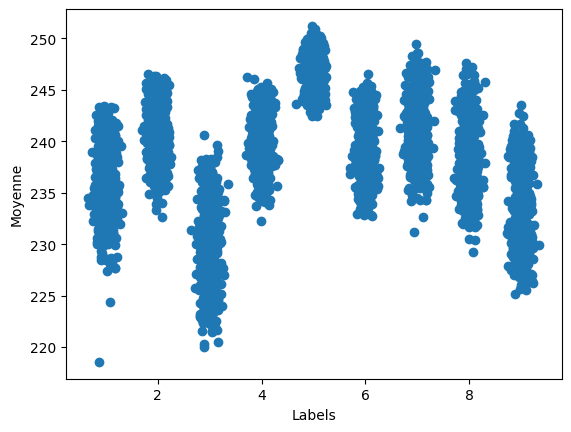

(5131, 76, 82)
(5131,)


In [2]:
train_data = train.Trainer(datapath = "data_resultsheets/Train/")
print(train_data.full_da.shape)
train_data.plot_mpi()
print(train_data.pict.shape)
print(train_data.label.shape)

(764, 6233)


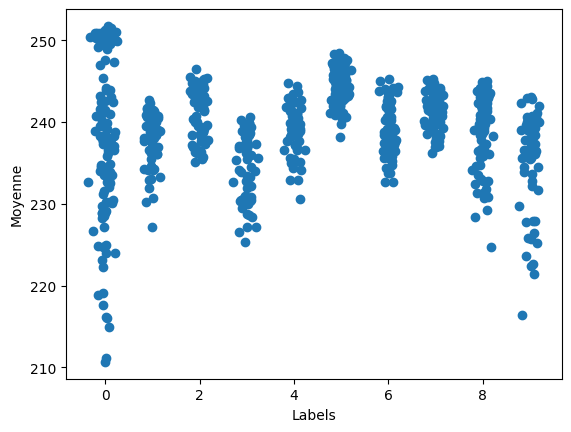

(764, 76, 82)
(764,)


In [77]:
test_data = train.Trainer(datapath = "data_resultsheets/Test/")
print(test_data.full_da.shape)
test_data.plot_mpi()
print(test_data.pict.shape)
print(test_data.label.shape)

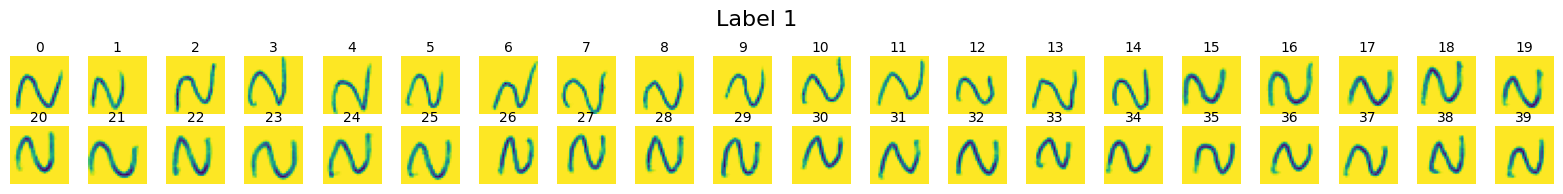

In [3]:
label_mask = train_data.label == 1
label_index = np.where(label_mask)[0]
random_index = random.choices(label_index, k=42)

indice_mask = [True if i in random_index else False for i in (range(len(train_data.label)))]
img_display.roi_display_jup(train_data.pict_redim, train_data.label, mask=indice_mask, row_size = 20)

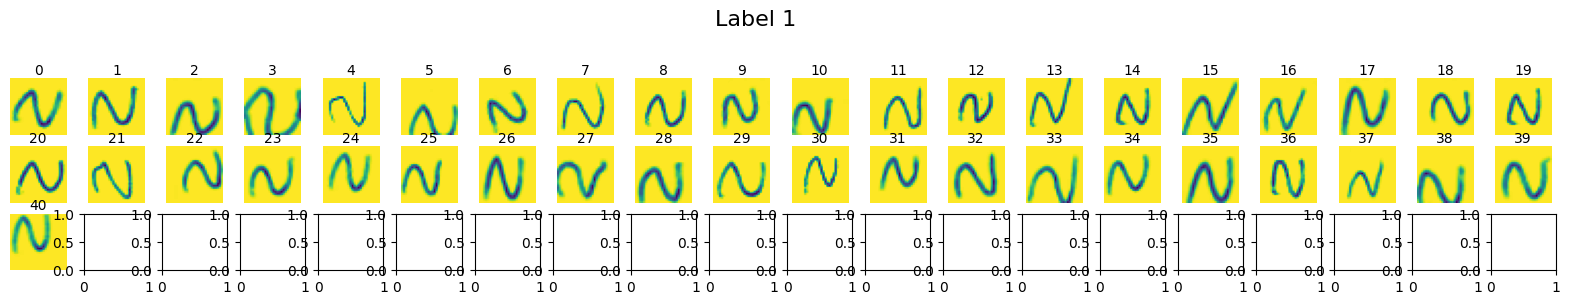

In [91]:
label_mask = y_train == 1
label_index = np.where(label_mask)[0]
random_index = random.choices(label_index, k=42)

indice_mask = [True if i in random_index else False for i in (range(len(y_train)))]
img_display.roi_display_jup(X_train, y_train, mask=indice_mask, row_size = 20)

In [4]:
pict = train_data.pict_redim.reshape(-1, 28, 28, 1)
label = train_data.label
print(pict.shape)

(5131, 28, 28, 1)


# Image augmentation

Type of layers available in Keras :

* RandomCrop layer : produce zoomed in pictures
* RandomFlip layer : symbols will not be correct afterwards, not used
* RandomTranslation layer : produce shifted pictures, up and down in both direction
* RandomRotation layer : produce slightly rotated pictures, clockwise and counterclockwise
* RandomZoom layer : produce pictures zoomed in or out on horizontal or vertical axes, resulting in mild picture deformation
* RandomContrast layer : combined with RandomBrightness layer to create varying line thickness
* RandomBrightness layer : see above

## RandomCrop

Seems like a valid approach as long as crop size is not too small

In [119]:
crop = keras.Sequential([
    keras.layers.RandomCrop(height = 24, width = 24, data_format="channels_last", seed=None),
    keras.layers.Resizing(height = 28, width = 28, data_format = "channels_last")])

In [120]:
pict_crop = crop(pict)
pict_crop = pict_crop.numpy()
print(pict_crop.shape)

(5131, 28, 28, 1)


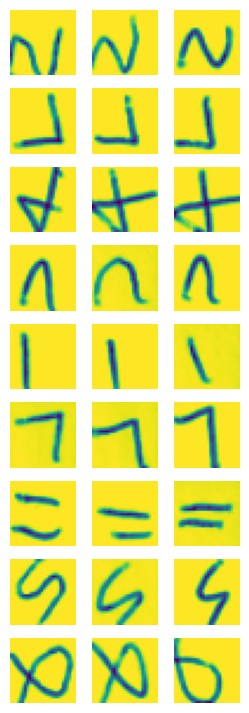

In [136]:
image_list = pict_crop

fig, axs = plt.subplots(9, 3, figsize=(3,9))
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=3)
    for i, pixels in enumerate(image_list[random_index]):
        axs[l-1, i].imshow(pixels)
        axs[l-1, i].axis('off')
    
plt.show()

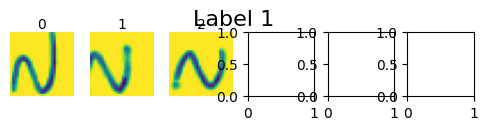

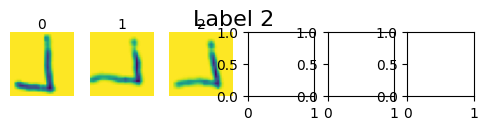

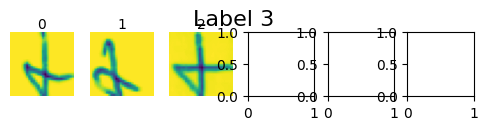

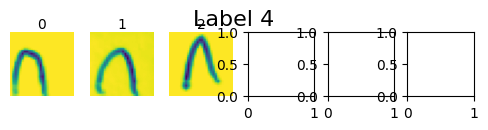

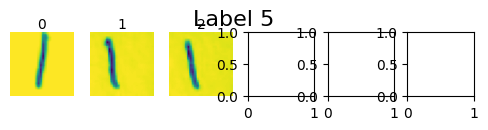

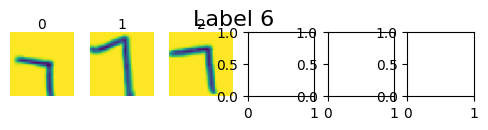

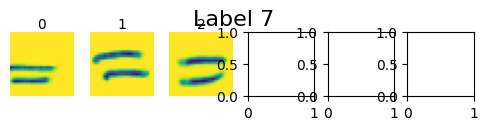

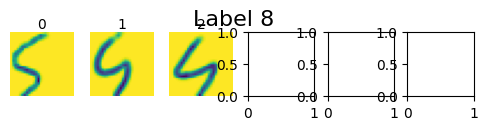

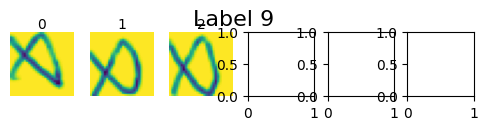

In [127]:
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=3)

    indice_mask = [True if i in random_index else False for i in (range(len(label)))]
    img_display.roi_display_jup(pict_crop, label, mask=indice_mask, row_size = 6)

In [79]:
denorm = pict_crop * 255
t = train.Dataset(denorm, label)
t.save_csv('crop_train')

## RandomTranslation

Parameters:
* fill_mode = 'constant' so that empty area are filled with pixel of value :
* fill_value = 1.0 to fill with white pixels

Seems also valid, although pictures with a slightly darker background lead to a sharp delimitation with the filled part.

In [137]:
translate = keras.Sequential([
    keras.layers.RandomTranslation(height_factor = (-0.2, 0.2), width_factor = (-0.2, 0.2),
                                   fill_mode="constant", interpolation="bilinear",
                                   seed=None, fill_value=1.0, data_format="channels_last")])

In [138]:
pict_translat = translate(pict)
pict_translat = pict_translat.numpy()
print(pict_translat.shape)

(5131, 28, 28, 1)


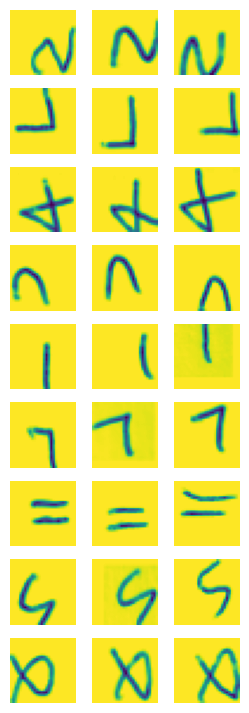

In [139]:
image_list = pict_translat

fig, axs = plt.subplots(9, 3, figsize=(3,9))
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=3)
    for i, pixels in enumerate(image_list[random_index]):
        axs[l-1, i].imshow(pixels)
        axs[l-1, i].axis('off')
    
plt.show()

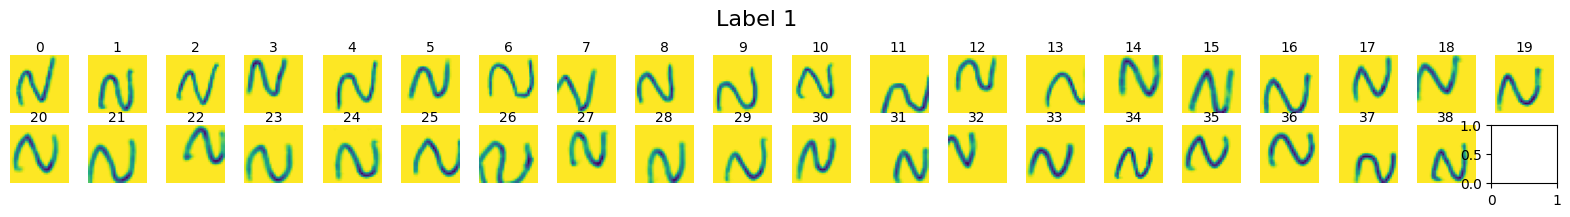

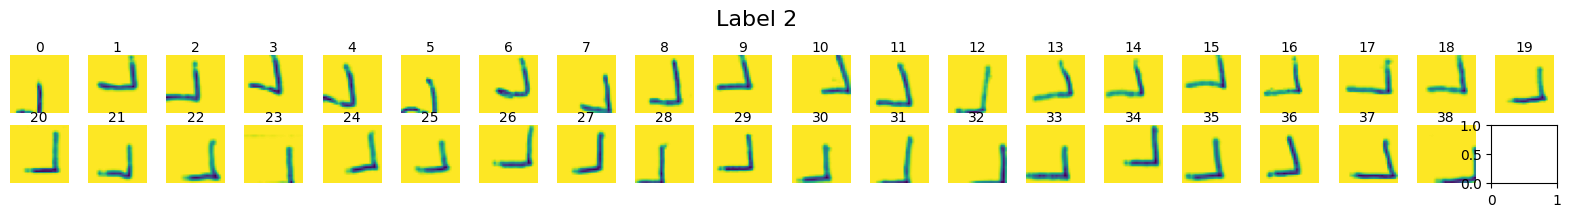

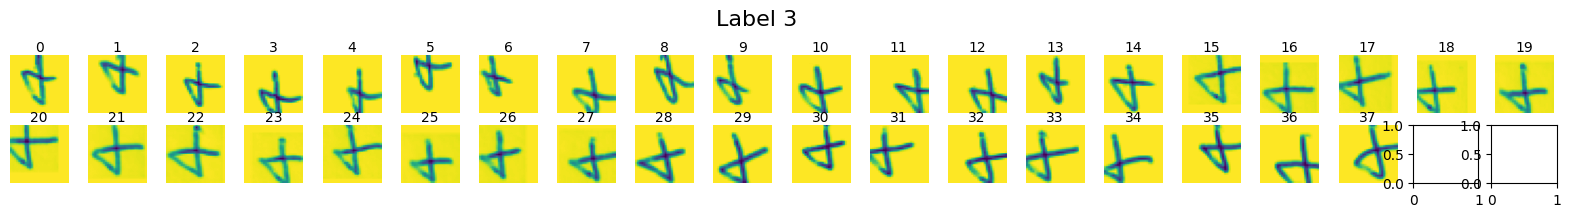

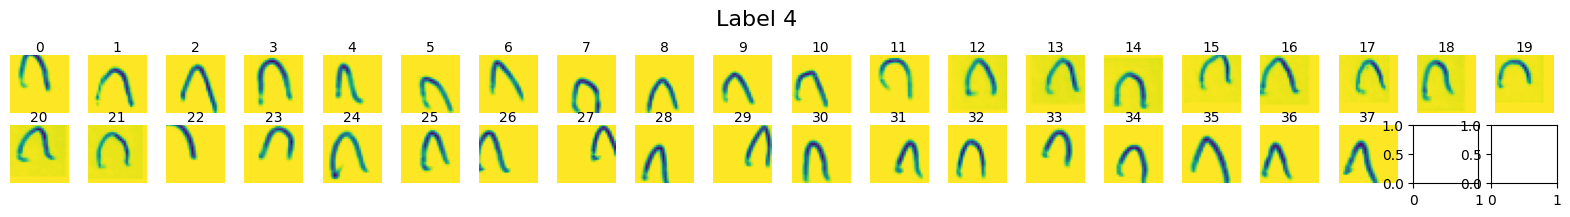

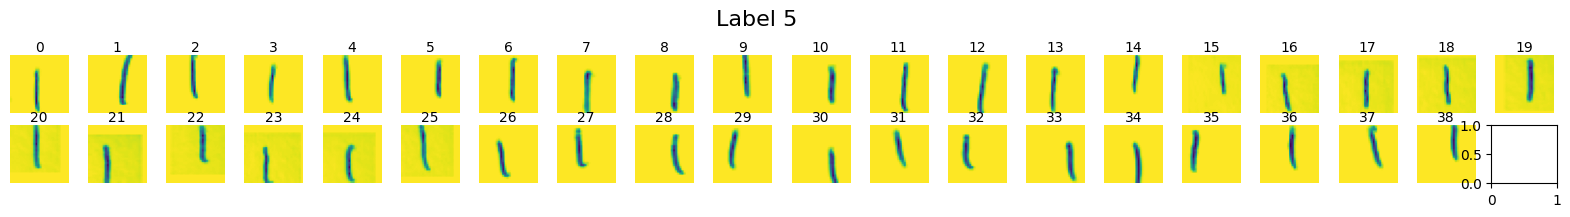

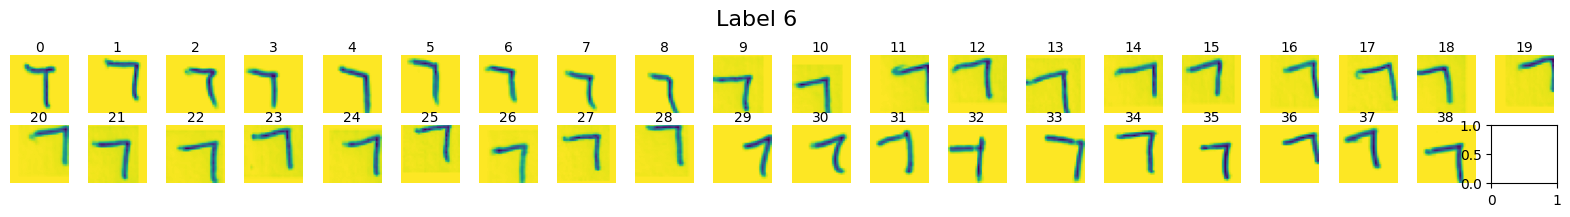

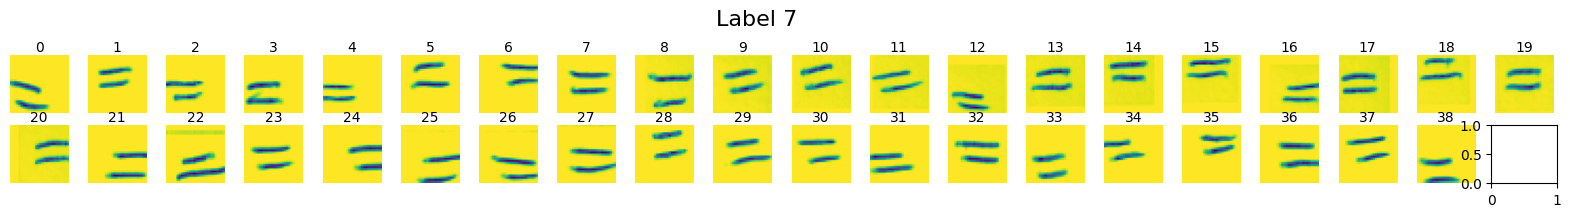

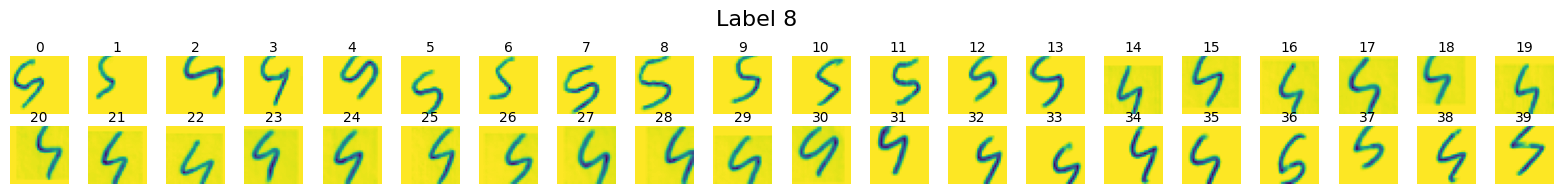

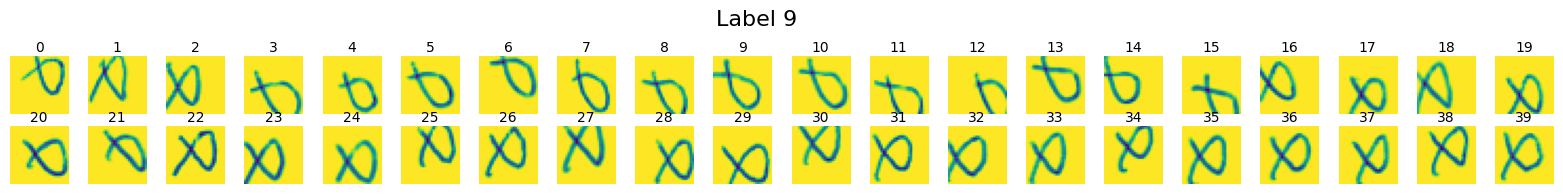

In [95]:
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=40)

    indice_mask = [True if i in random_index else False for i in (range(len(label)))]
    img_display.roi_display_jup(pict_translat, label, mask=indice_mask, row_size = 20)

In [96]:
denorm = pict_translat * 255
t = train.Dataset(denorm, label)
t.save_csv('translation_train')

## RandomRotation

Parameters :
* factor = 0.7 optimized with several trials to have mild transformations where the symbol is still correct
* fill_mode = 'constant' and fill_value = 1.0 to have empty area filled with white pixels
* value_range = (0., 1.) because we use normalized pictures

In [15]:
rotate = keras.Sequential([
    keras.layers.RandomRotation(factor = 0.07, fill_mode="constant",
    interpolation="bilinear",
    seed=None, fill_value=1.0,
    value_range=(0., 1.),
    data_format="channels_last")])

In [16]:
pict_rot = rotate(pict)
pict_rot = pict_rot.numpy()
print(pict_rot.shape)

(5131, 28, 28, 1)


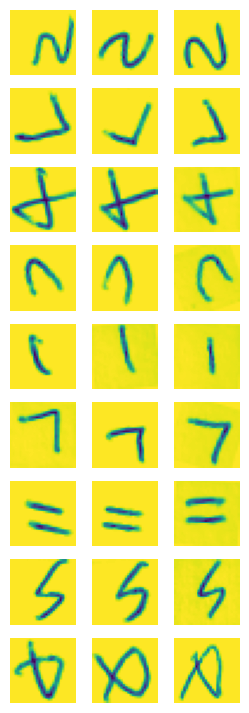

In [140]:
image_list = pict_rot

fig, axs = plt.subplots(9, 3, figsize=(3,9))
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=3)
    for i, pixels in enumerate(image_list[random_index]):
        axs[l-1, i].imshow(pixels)
        axs[l-1, i].axis('off')
    
plt.show()

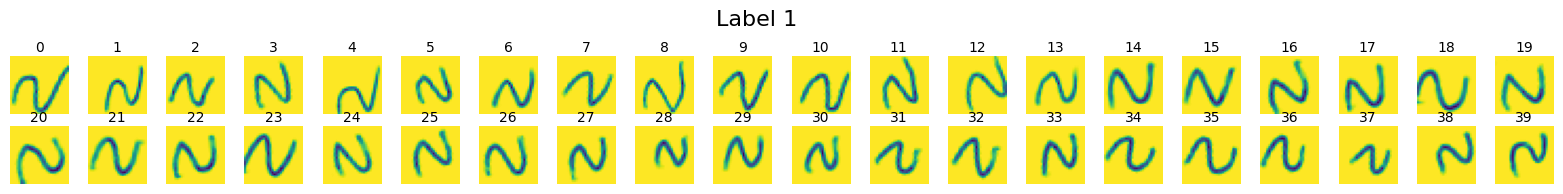

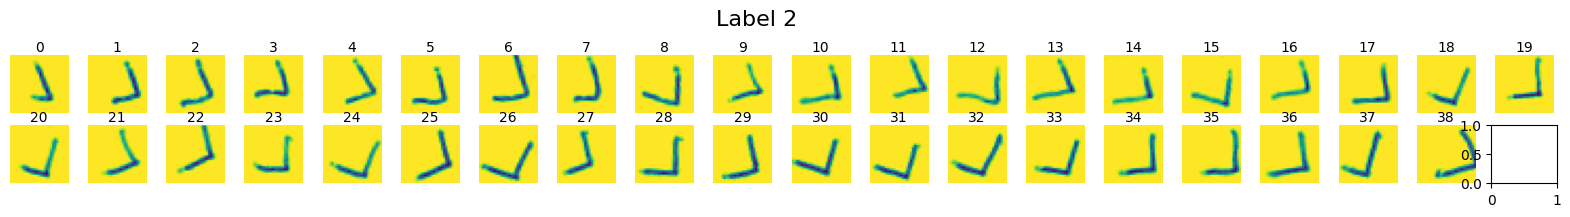

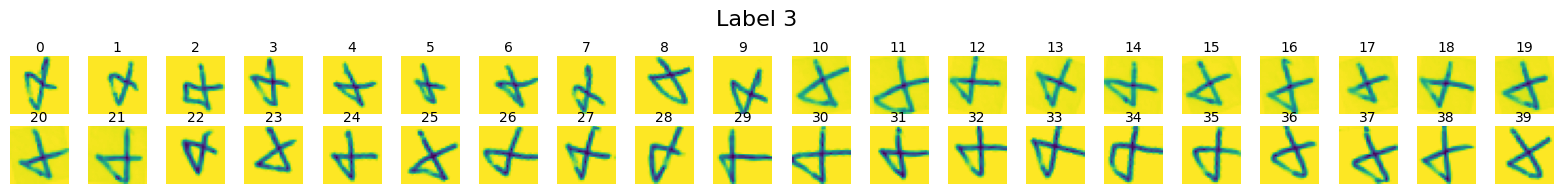

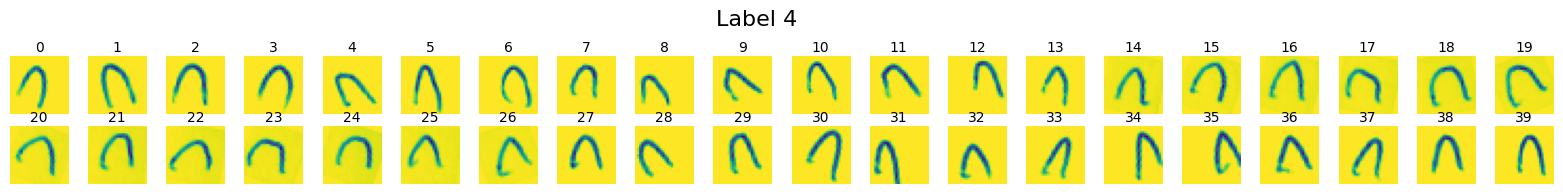

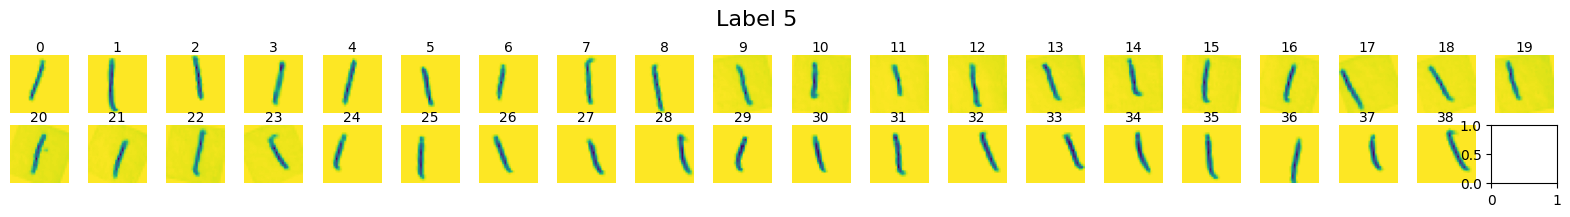

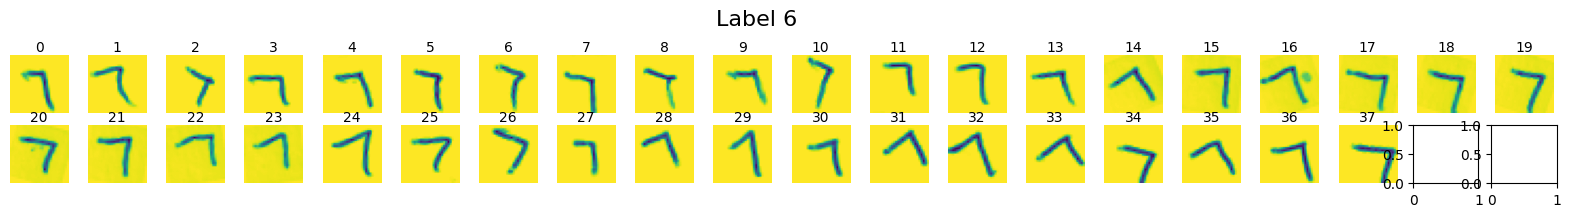

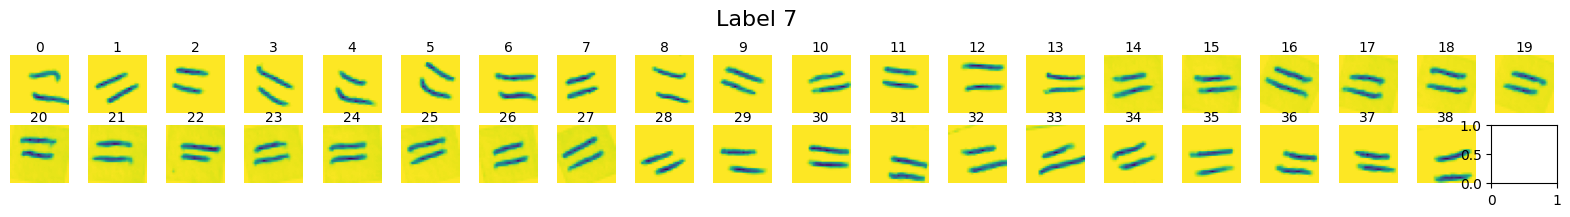

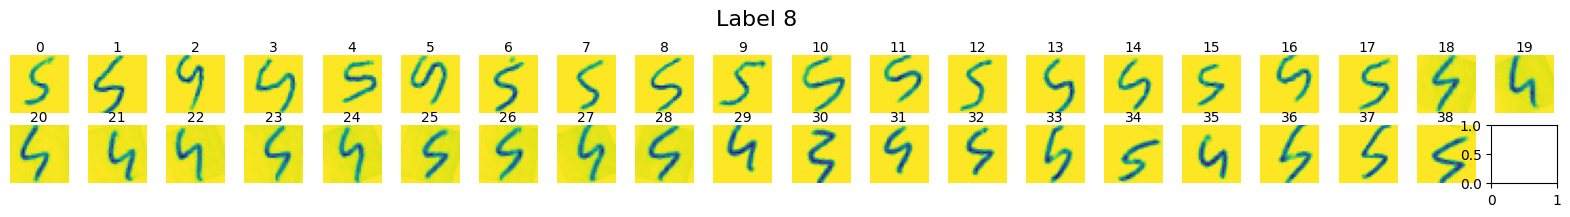

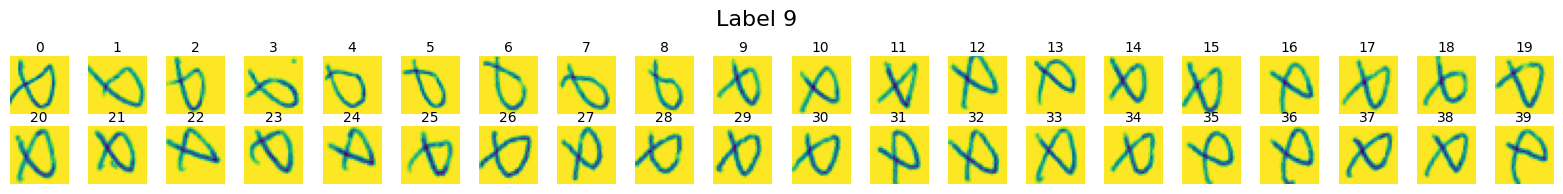

In [17]:
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=40)

    indice_mask = [True if i in random_index else False for i in (range(len(label)))]
    img_display.roi_display_jup(pict_rot, label, mask=indice_mask, row_size = 20)

In [18]:
denorm = pict_rot * 255
t = train.Dataset(denorm, label)
t.save_csv('rotation_train')

## RandomZoom

Parameters :
* height_factor : 0.2 means zoomed in (-0.2) or out (+0.2) by 20%
* width_factor : None means preserve the aspect ratio when zooming on the height factor. Here we set a value to also have mild deformation of the images

In [25]:
zoom = keras.Sequential([
    keras.layers.RandomZoom(height_factor = 0.3,
    width_factor=0.3,
    fill_mode="constant",
    interpolation="bilinear",
    seed=None,
    fill_value=1.0,
    data_format="channels_last")])

In [26]:
pict_zoom = zoom(pict)
pict_zoom = pict_zoom.numpy()
print(pict_zoom.shape)

(5131, 28, 28, 1)


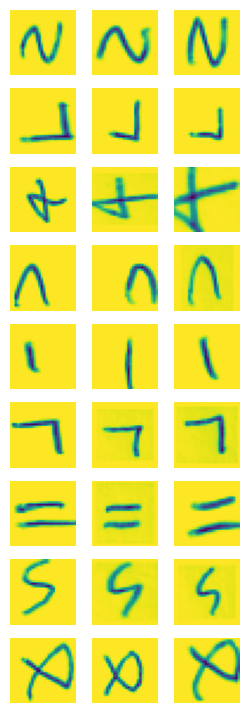

In [142]:
image_list = pict_zoom

fig, axs = plt.subplots(9, 3, figsize=(3,9))
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=3)
    for i, pixels in enumerate(image_list[random_index]):
        axs[l-1, i].imshow(pixels)
        axs[l-1, i].axis('off')
    
plt.show()

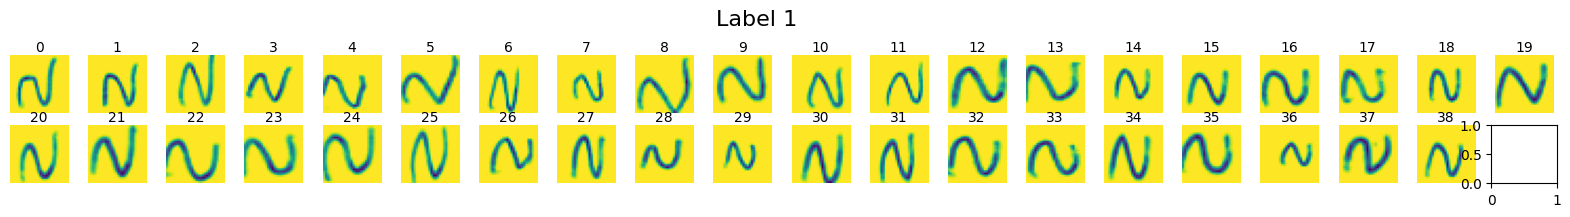

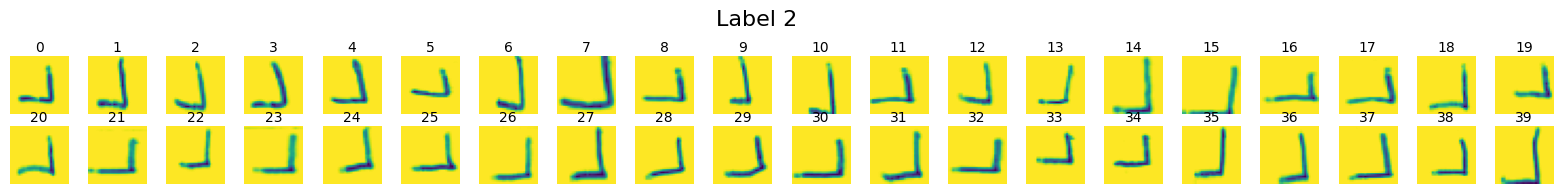

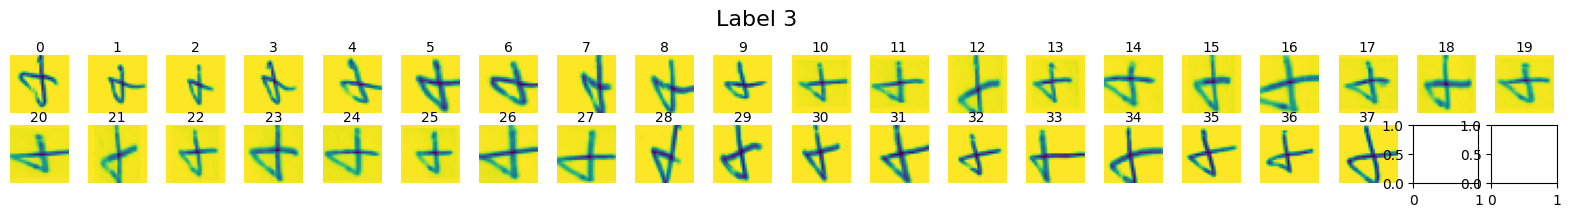

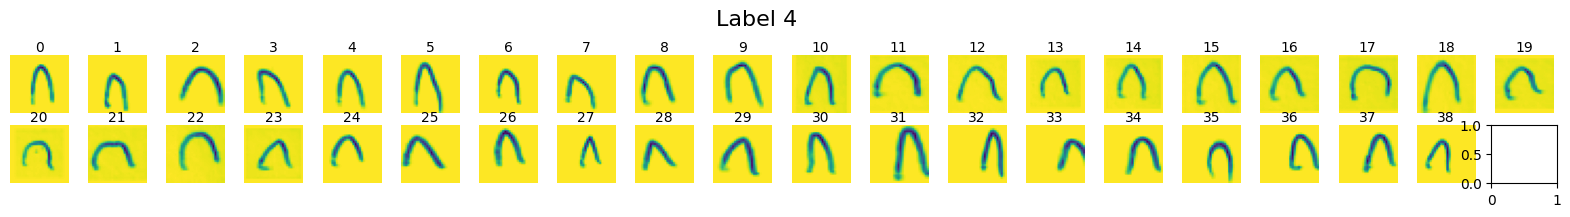

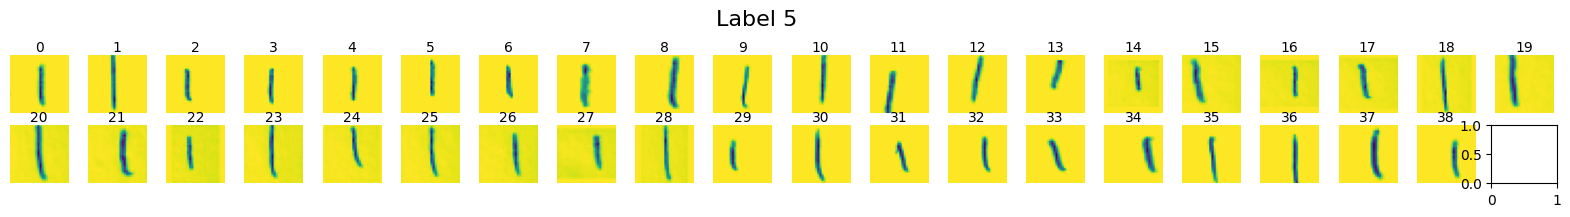

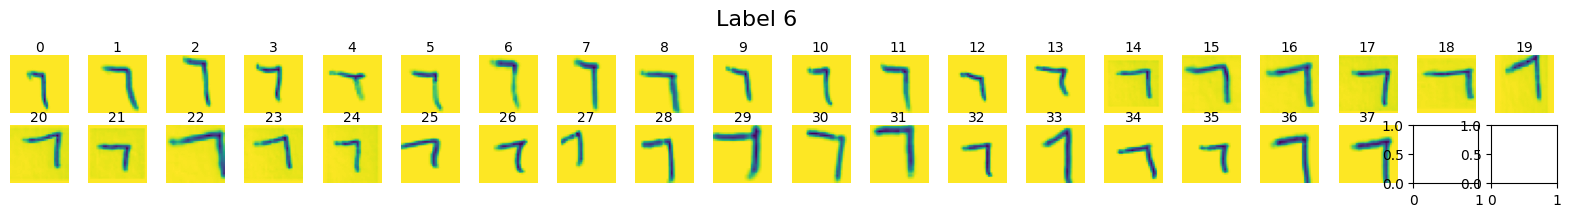

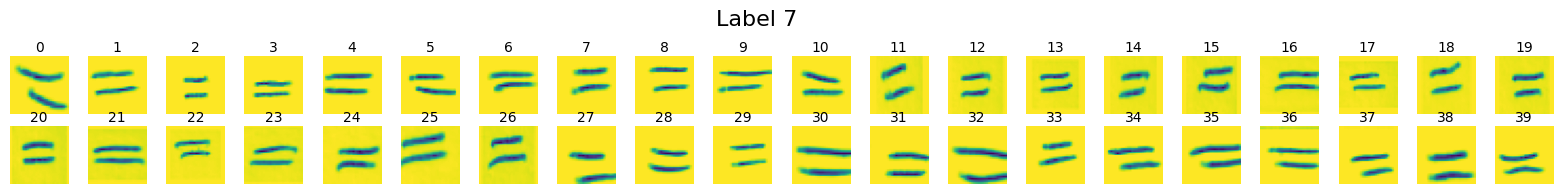

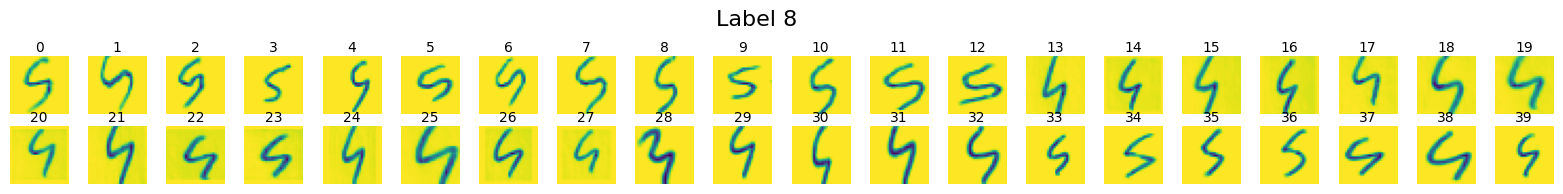

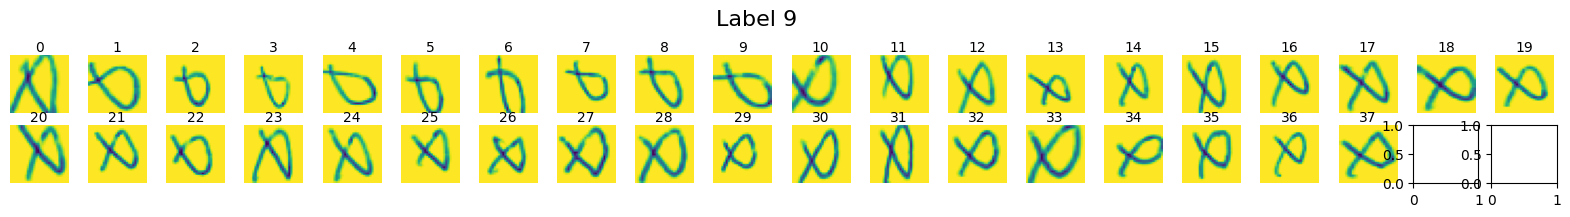

In [28]:
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=40)

    indice_mask = [True if i in random_index else False for i in (range(len(label)))]
    img_display.roi_display_jup(pict_zoom, label, mask=indice_mask, row_size = 20)

In [29]:
denorm = pict_zoom * 255
t = train.Dataset(denorm, label)
t.save_csv('zoomed_train')

## RandomContrast and RandomBrightness

Adjustment result in variable thickness of lines. The maximum values that do not result in line dotting were picked.

In [60]:
contrast = keras.Sequential([
    keras.layers.RandomContrast(factor=0.5, seed=None),
    keras.layers.RandomBrightness(factor=0.25, value_range=(0.0, 1.0), seed=None)])

In [61]:
pict_bc = contrast(pict)
pict_bc = pict_bc.numpy()
print(pict_bc.shape)

(5131, 28, 28, 1)


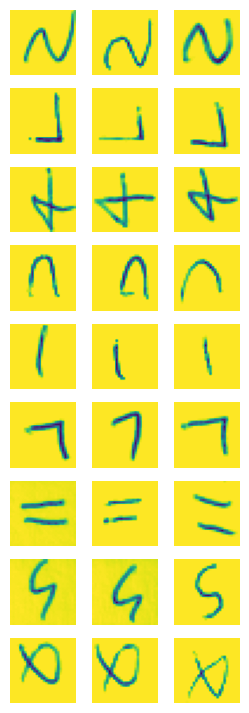

In [143]:
image_list = pict_bc

fig, axs = plt.subplots(9, 3, figsize=(3,9))
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=3)
    for i, pixels in enumerate(image_list[random_index]):
        axs[l-1, i].imshow(pixels)
        axs[l-1, i].axis('off')
    
plt.show()

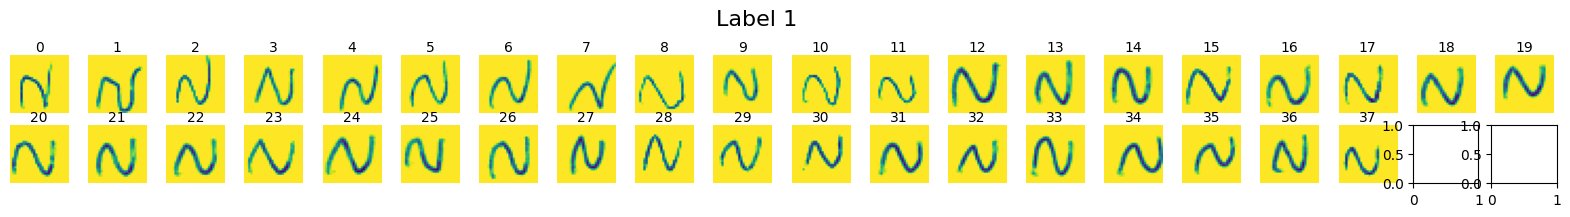

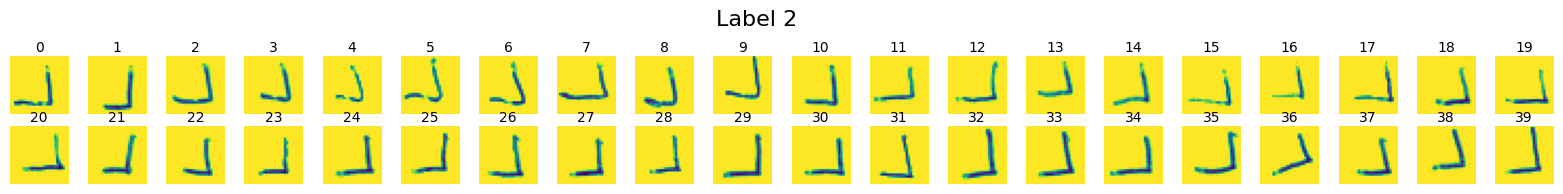

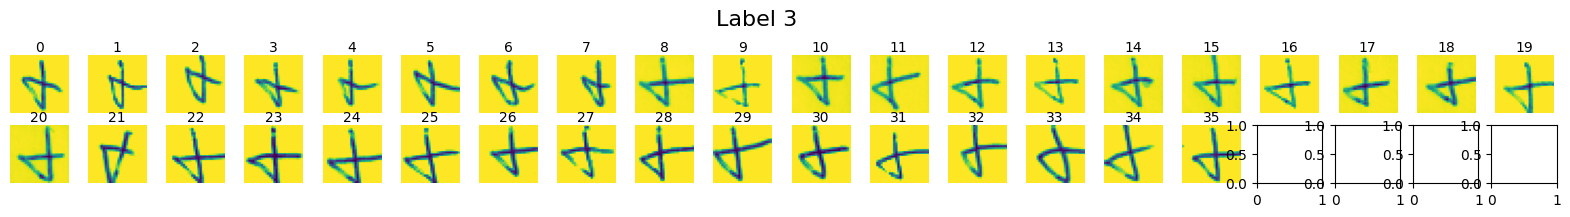

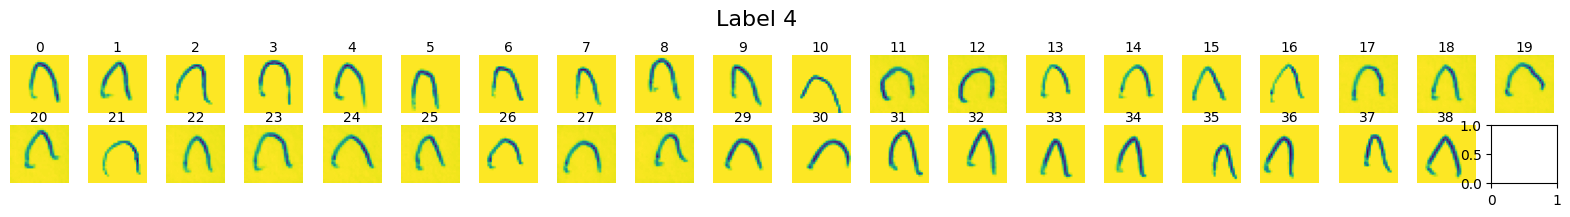

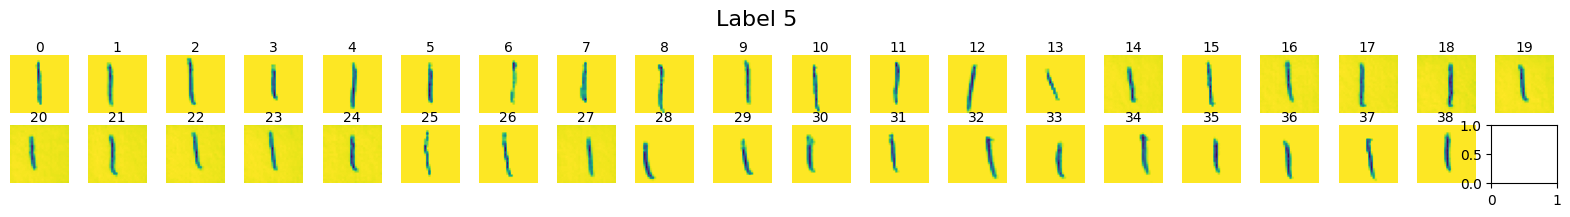

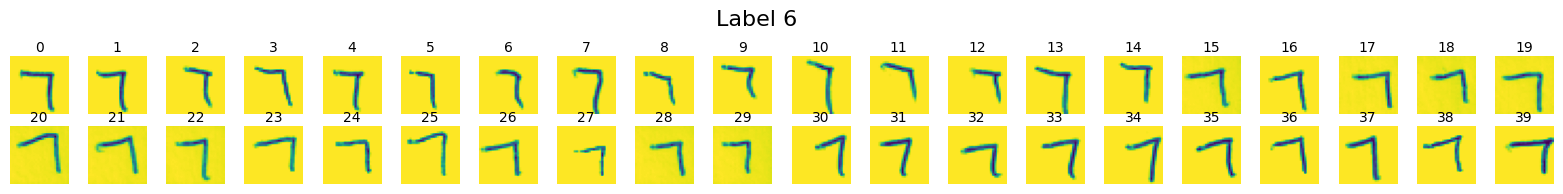

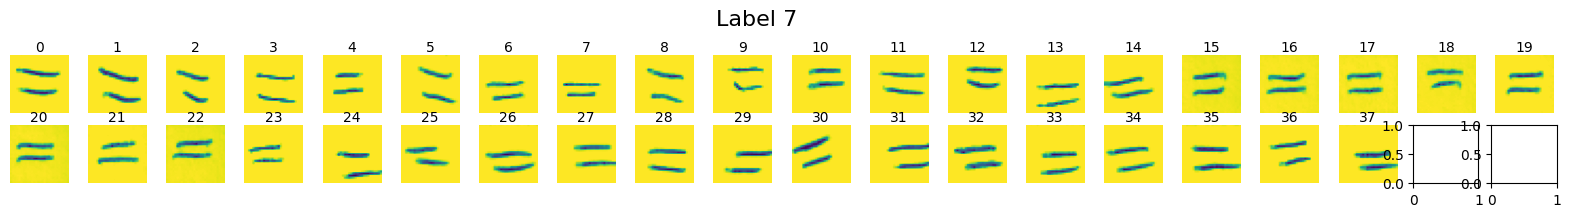

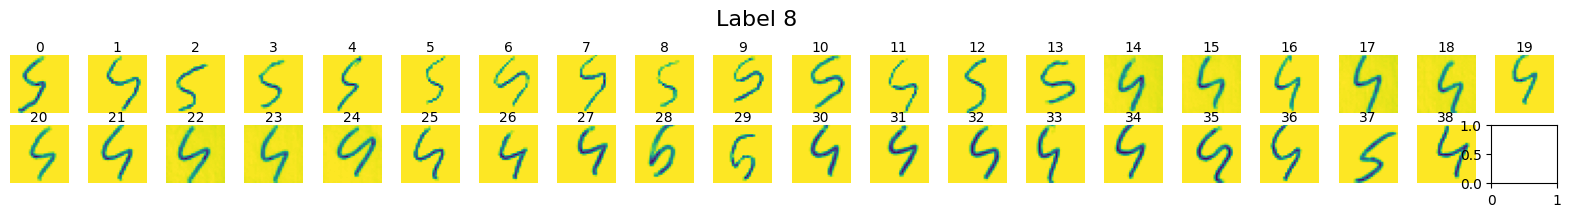

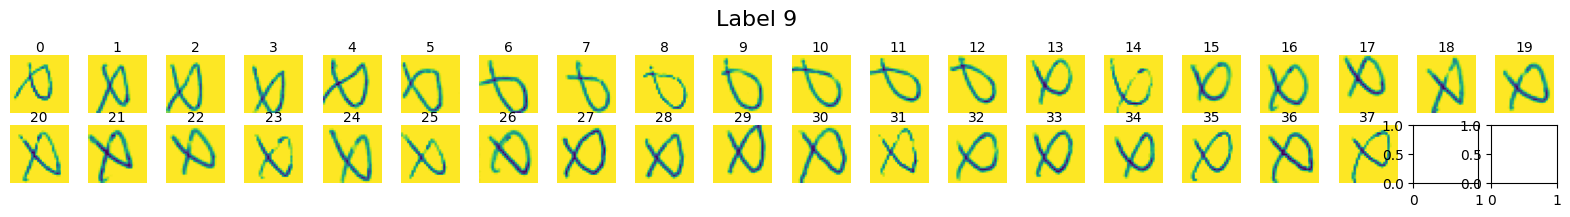

In [62]:
for l in np.unique(label):
    label_mask = label == l
    label_index = np.where(label_mask)[0]
    random_index = random.choices(label_index, k=40)

    indice_mask = [True if i in random_index else False for i in (range(len(label)))]
    img_display.roi_display_jup(pict_bc, label, mask=indice_mask, row_size = 20)

In [63]:
denorm = pict_bc* 255
t = train.Dataset(denorm, label)
t.save_csv('bc_train')

# Load augmented dataset

Loads from augmented data csv file which contain the pictures and the labels.
Then stack together the train dataset with the train augmented dataset.

In [65]:
import importlib

# make changes to example.py file

importlib.reload(train)

<module 'train' from 'C:\\Users\\Utilisateur\\Documents\\Stage\\TREC - Codage\\trec-coding\\train.py'>

In [66]:
train_data_aug = train.Trainer(datapath = "data_resultsheets/Train_aug/", ext_w=28, ext_h=28)
print(train_data_aug.full_da.shape)
print(train_data_aug.pict.shape)
print(train_data_aug.label.shape)

(25655, 785)
(25655, 28, 28)
(25655,)


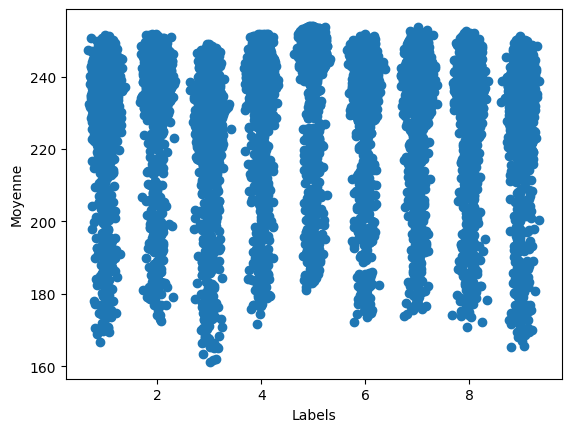

In [67]:
train_data_aug.plot_mpi()

In [79]:
all_pict = np.vstack((train_data.pict_redim, train_data_aug.pict_redim))
print(all_pict.shape)
all_labels = np.hstack((train_data.label, train_data_aug.label))
print(all_labels.shape)

(30786, 28, 28)
(30786,)


# Train-test-val split

Here we use all data from test folder as test dataset.
We shuffle and split the train to obtain val dataset.

In [78]:
X_test = test_data.pict_redim
y_test = test_data.label

In [80]:
X_train, X_val, y_train, y_val = train_test_split(all_pict, all_labels, test_size=0.1, random_state=42)

Training DataArray :
(27707, 28, 28)
(27707,)
Test DataArray :
(764, 28, 28)
(764,)
Val DataArray :
(3079, 28, 28)
(3079,)


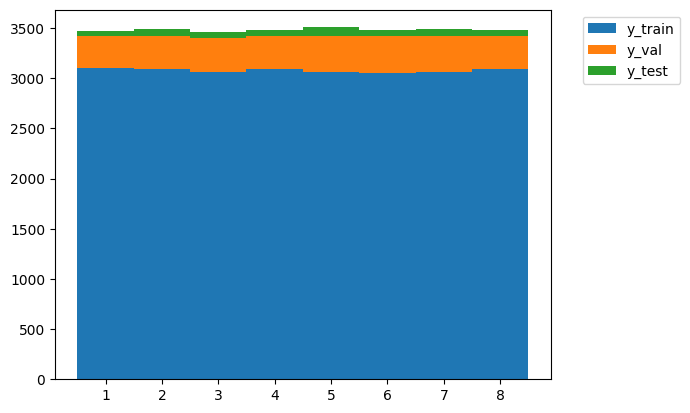

In [81]:
print("Training DataArray :")
print(X_train.shape)
print(y_train.shape)

print("Test DataArray :")
print(X_test.shape)
print(y_test.shape)

print("Val DataArray :")
print(X_val.shape)
print(y_val.shape)

plt.hist([y_train.flatten(), y_val.flatten(), y_test.flatten()], bins=np.arange(0.5, 9.5, 1), stacked=True, label=['y_train', 'y_val', 'y_test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Training of the model

We use the best model found at previous step, which is Convolutive Neural Network (CNN), with the Conv-Conv-Pool-Conv-Conv-Pool structure (vgg like).

Hyperparameters are set as the best values found in previous step, excepted for :
* batch size was multiplied by 5, since the size of training dataset was multiplied by 5
* learning rate was lowered since model had difficulties to converge

In [82]:
x_train = X_train.reshape(-1, 28, 28, 1)
x_val = X_val.reshape(-1, 28, 28, 1)
x_test = X_test.reshape(-1, 28, 28, 1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(x_train.min(), x_train.max())

(27707, 28, 28, 1)
(3079, 28, 28, 1)
(764, 28, 28, 1)
(27707,)
(3079,)
(764,)
0.0 1.0


In [105]:
def get_model_cnn(hidden1):
    shape = (28,28,1)
    hidden1 = 200
    lr = 0.001
    conv1 = 8
    kernel1 = (5, 5)
    kernel2 = (3, 3)
    padding1 = 'same'
    padding2 = 'valid'
    dropout1 = 0
    dropout2 = 0
    dropout3 = 0
    batchnorm = False

    model = keras.models.Sequential([
                keras.layers.Input(shape, name='InputLayer'),
                keras.layers.Conv2D(conv1, kernel_size=kernel1, activation='relu',padding=padding1),
                keras.layers.Conv2D(conv1, kernel_size=kernel1, activation='relu',padding=padding1)])
    if batchnorm:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(keras.layers.Dropout(dropout1))
    model.add(keras.layers.Conv2D(conv1*2, kernel_size=kernel2, activation='relu',padding=padding2))
    model.add(keras.layers.Conv2D(conv1*2, kernel_size=kernel2, activation='relu',padding=padding2))
    if batchnorm:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(keras.layers.Dropout(dropout2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(hidden1, activation='relu'))
    if batchnorm:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropout3))
    model.add(keras.layers.Dense(9, activation= 'softmax', name='Output'))
    
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate = lr),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],)
    return model

In [106]:
modelCNN = get_model_cnn(200)
modelCNN.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 8)           │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 8)           │           1,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 10, 10, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 200)                 │          80,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 9)                   │           1,809 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,313 (341.07 KB)

 Trainable params: 87,313 (341.07 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
callbacksCNN = [keras.callbacks.ModelCheckpoint(filepath="models/CNN_{epoch:02d}-{val_acc:.3f}.keras", monitor = 'val_acc',
                                                      save_best_only = True, mode = 'max', initial_value_threshold = 0.7),
                      keras.callbacks.EarlyStopping(monitor = 'val_acc', mode = 'max', patience=5, start_from_epoch = 5, 
                                                   restore_best_weights = True)]

In [108]:
batch_size = 128
epochs = 50

historyCNN = modelCNN.fit(
    x_train,
    y_train-1,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val-1),
    callbacks=callbacksCNN,
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - acc: 0.6078 - loss: 1.1769 - val_acc: 0.9354 - val_loss: 0.2132
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 0.9512 - loss: 0.1589 - val_acc: 0.9685 - val_loss: 0.1067
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.9764 - loss: 0.0821 - val_acc: 0.9753 - val_loss: 0.0749
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9839 - loss: 0.0540 - val_acc: 0.9795 - val_loss: 0.0642
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9892 - loss: 0.0359 - val_acc: 0.9831 - val_loss: 0.0569
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.9932 - loss: 0.0244 - val_acc: 0.9857 - val_loss: 0.0437
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - acc: 0.9937 - loss: 0.0224 - val_acc: 0.9867 - val_loss: 0.0518
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 0.9919 - loss: 0.0277 - val_acc: 0.9890 - val_loss: 0.0373
Epoch 9/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/

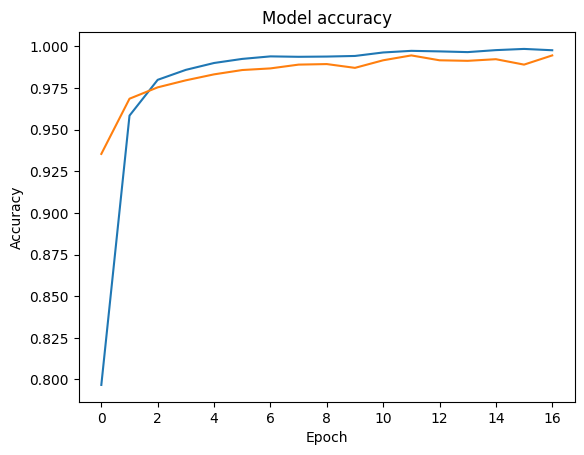

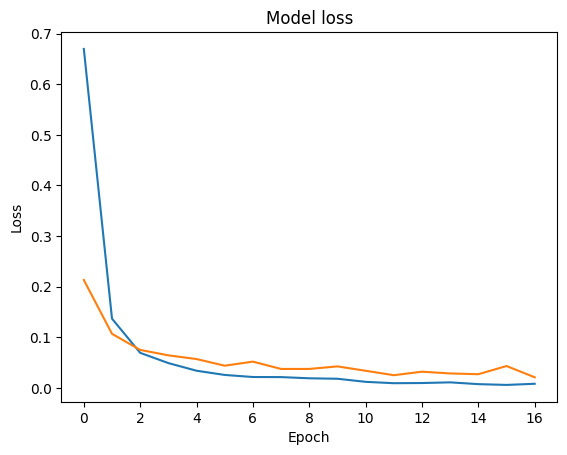

In [109]:
# Plot training & validation accuracy values
plt.plot(historyCNN.history['acc'], label = 'train')
plt.plot(historyCNN.history['val_acc'], label = 'test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss values
plt.plot(historyCNN.history['loss'], label = 'train')
plt.plot(historyCNN.history['val_loss'], label = 'test')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluation of model

Evaluation is done using the Evaluator object, which can be instanciated with test dataset (X_test the images and y_test the labels).
Prediction can be made with a model saved during the training phase by providing its path.
Labels are inferred from prediction probabilities using the argmax function, only when the max probability is >  0.7.
Otherwise label 0 (error) is assigned, meaning the model cannot make a reliable prediction.

The Evaluator object can then perform correction method, called by specifying correct labels and test labels to compare them to.
Labels are stored in Evaluator in the label attribute which is a dictionnary. In the correction method, confusion matrix and accuracy are calculated
using scikit learn API.

Following method metrics_calculation can be called to calculate custom metrics. We calculate these metrics to have a per label view of false positives and false negatives. This is important since in our model, we want to minimize false positive more importantly than minimizing false negative.
* False positives = symbols labelled correct while they are:
  * an error : FP_error
  * or a different symbol : FP_symbol
* False negative = symbols which are correct but are labelled as:
  * an error : FN_error
  * or a different symbol: FN_symbol

To evaluate the model, we use the test with the errors (0).

In [111]:
evaCNN = evaluate.Evaluator(x_test, y_test)
print(evaCNN.X.shape)
print(evaCNN.labels['train_labels'].shape)
evaCNN.predict(modelpath = "models/CNN_10-0.996_20240611_t2.keras")
print(evaCNN.labels['predicted_labels'].shape)

(764, 28, 28, 1)
(764,)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(764,)


In [115]:
evaCNN.correction(correct_labels = evaCNN.labels['train_labels'], test_labels = evaCNN.labels['predicted_labels'], keeper_mask=evaCNN.fill_mask)
evaCNN.metrics_calculation()

Accuracy : 0.8732824427480916, errors : 0.12671755725190836


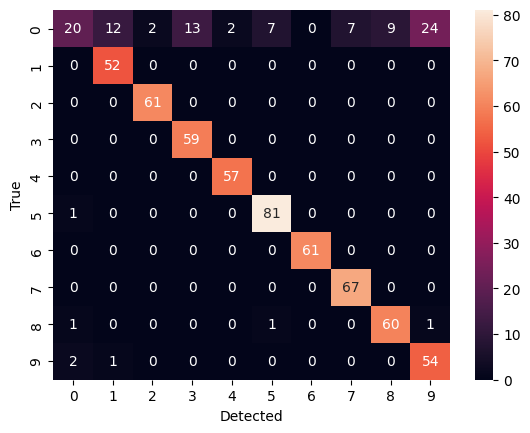

In [116]:
evaCNN.cm_plot()
print(f'Accuracy : {evaCNN.g_accuracy}, errors : {evaCNN.g_error}')

0    1         2         3         4         5    6  \
Precision  0.833333  0.8  0.968254  0.819444  0.966102  0.910112  1.0   
Recall     0.208333  1.0  1.000000  1.000000  1.000000  0.987805  1.0   

                  7         8         9  
Precision  0.905405  0.869565  0.683544  
Recall     1.000000  0.952381  0.947368

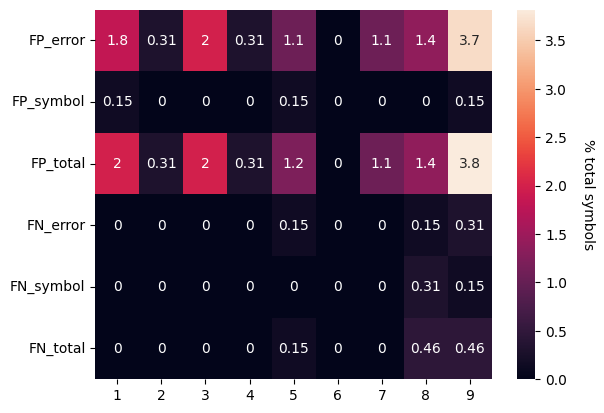

In [117]:
evaCNN.metrics_plot()
evaCNN.metrics_df()